## ML-based detection of HIV drug resistance mutations

This project uses publicly available HIV-1 NGS data.  

### Data sources

The data used in this project is publicly available HIV-1 NGS data. It is obtained from the Sequence Read Archive (SRA) and the European Nucleotide Archive (ENA), accessions numbers; PRJNA517147, PRJNA486832, PRJNA669549, PRJNA761121, PRJNA340290, PRJNA531904, PRJDB3502, PRJNA448668 and PRJNA554675. The data were generated as part of projects investing the diversity of HIV-1 in different populations and application of NGS technologies in HIV drug resistance testing. The table below shows the number of samples and treatment status of the study participants. More on data description [here](#).

| No. |  Bioproject  | No. of samples | Genome region | Population | Treatment status | Line of treatment|Reference|
|-----|--------------|----------------|---------------|------------|------------------|------------------|---------|
| 1   |  PRJNA517147 | 68             | PR/RT         |    USA     |    Treated       |                  |         |
| 2   |  PRJNA486832 | 125            | PR/RT/IN      |    USA     |    Treated       |                  |         |
| 3   |  PRJNA669549 | 874            | PR/RT         |South Africa|    Naive         |   1st/2nd/3rd    |         |
| 4   |  PRJNA761121 | 42             | PR/RT/IN      |   Nigeria  |    Treated       |                  |         |
| 5   |  PRJNA340290 | 255            | PR/RT         | Nicaragura |    Naive         |                  |         |
| 6   |  PRJNA531904 | 109            | PR/RT/IN      |  Ethiopia  |    Naive         |                  |         |
| 7   |  PRJDB3502   | 92             | PR/RT/IN      |   Japan    |    Treated       |                  |         |
| 8   |  PRJNA448668 | 134            | IN            |   France   |    Treated       |                  |         |
| 9   |  PRJNA554675 | 380            | IN            |   Uganda   |  Naive/Treated   |   1st/2nd/3rd    |         |
| 10  |  PRJNA419915 | 54             | PR/RT         |   Brazil   |  Treated         |                  |         |

PR: Protease, RT: Reverse Transcriptase, IN: Integrase, USA: United States of America

### Bioinformatics data analysis

FASTQ files where analysed using the procedure outline [here](#). Briefly, the quality of the data was checked using FastQC and aggregated using MultiQC. Adaptor and quality trimming was done using trim-galore. As part of the quasitools pipeline, trimmed reads were aligned to the HIV subtype B reference genome, accession number HXB. HIV variant calling was done using HyDRA. Known HIV drug resistance mutations were detected using the Stanford HIV drug resistance database. Variant call data was combined accross samples with genome region, population and treatment status data.  An amino acid amino acid mutation was represented as a binary variable with 1 for presence and 0 for its absence in a certain sample. Lastly, the data was grouped by genomic region i.e PR, RT, IN and written off as CSV files.

### Machine learning models

Using the data generated above, we set out to build machine learning models to classify between sequences from naive and treated patients. In this case, we are using the amino mutations as features. The target is treatment status (naive/treated). Our aim here is 2-fold;

* To identify the best performing model.
* To identify the most important features (amino acid mutations) that drive the prediction ability of the models.

We use three machine learning algorithms namely; Support Vector Machines (SVM), Random Forests (RF) and Gradient Boosting Machines (GBM). The choice of these algorithms is based on the interpretability and popularity with machine-learning based HIV drug resistance prediction. Classifier performance is based on Area Under the Receiver Operating charactieristic Curve (ROC). Model performance is assessed using model-specific importance measures, that is coefficients for SVMs and Gini impunity/Mean decrease accuracy in RF and GBM. We use sklearn for Model building, evaluation and feature importance. We use packages plotnine and seaborn for visualising the results. This section is described in detail [here](#).

Import required libraries

In [1]:
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance, partial_dependence
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, ConfusionMatrixDisplay
import numpy as np
import pandas as pd
from plotnine import * 

Loading amino acid mutation datasets

In [2]:
variants_data = pd.read_csv('data/RTI.csv')
#variants_data.head()
stanford_muts = pd.read_csv('data/Stanford-resistance-comments.csv')
stanford_mut_list = set(stanford_muts['Mutation'])

Specify the parameters required downstream

In [3]:
target = 'Status'
drop_vars = ['Status','Sample', 'Subtype']
test_size = 0.2
pos_label = 'Treated'
n_top_features = 20
gene = 'RT'
algor_colors = ["#6082B6","#2AAA8A","#E3963E"]

We define some helper functions to be used for different tasks later on.

In [4]:
def get_potential_drms(importance_df, stanford_mut_list):
    imp_muts = importance_df[abs(importance_df.Importance)>0]
    mut_list = set(imp_muts['Feature_names'])
    known_drms = mut_list.intersection(stanford_mut_list)
    potential_drms = mut_list.difference(known_drms)
    return known_drms, potential_drms

def compute_sens_spec(cm):
    tn = cm.confusion_matrix[0,0]
    fp = cm.confusion_matrix[0,1]
    fn = cm.confusion_matrix[1,0]
    tp = cm.confusion_matrix[1,1]
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)
    return sens, spec

Isolate the target variable and the feature variables
Split data into training and test dataset. Here we use 20% of the dataset as test data

In [5]:
y = variants_data[[target]].values.ravel()
X = variants_data.drop(drop_vars, axis = 'columns')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)

#### Suport Vector Machine classifier

Run the classifier trained above on the test dataset, obtain the ROC curve and the AUC. 
Obtain feature importance. Pick the coefficients of the model, convert the data in a pandas dataframe, sort it by the feature importance and pick a given number of top features (20 in this case) to be used for visualisations.

Sensitivity: 0.8
Specificity: 0.94
AUC: 0.97
No. of known DRMs: 48
No. of other Mutations: 401


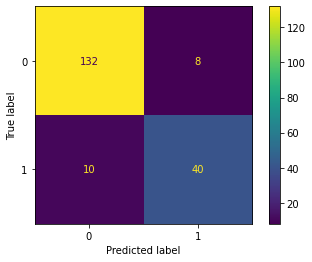

In [6]:
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_score = clf.decision_function(X_test)

cm = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred))
cm.plot()
sens, spec = compute_sens_spec(cm)
fpr_svm, tpr_svm, thr_svm = roc_curve(y_test, y_score, pos_label=pos_label)
auc_svm = auc(fpr_svm, tpr_svm)

print("Sensitivity: " + str(round(sens,2)))
print("Specificity: " + str(round(spec,2)))
print("AUC: "+str(round(auc_svm,2)))

model_imp = clf.coef_[0] #this is for SVM linear
feature_names = list(X.columns.values)
importance = list(abs(model_imp))
importance_dict = {'Feature_names':feature_names, 'Importance':importance, 'Algorithm':'SVM', 'Gene':gene}
imp_df = pd.DataFrame(importance_dict)
imp_df_svm_ = imp_df.sort_values('Importance', ascending=False)
imp_df_svm = imp_df_svm_.head(n_top_features)
known, potential = get_potential_drms(imp_df, stanford_mut_list)
print("No. of known DRMs: "+str(len(known)))
print("No. of other Mutations: "+str(len(potential)))

#### Random forest classifier

Sensitivity: 0.76
Specificity: 0.99
AUC: 0.98
No. of known DRMs: 57
No. of other Mutations: 543


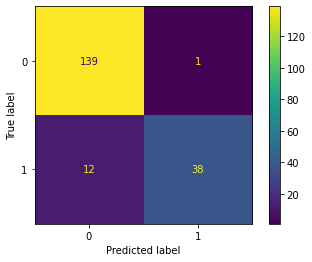

In [7]:
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
y_test_pred = clf.predict_proba(X_test)
fpr_rf, tpr_rf, thr_rf = roc_curve(y_test, y_test_pred[:,1], pos_label=pos_label)
auc_rf = auc(fpr_rf, tpr_rf)
cm = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred))
sens, spec = compute_sens_spec(cm)
print("Sensitivity: " + str(round(sens,2)))
print("Specificity: " + str(round(spec,2)))
print("AUC: "+str(round(auc_rf,2)))
cm.plot()

model_imp = clf.feature_importances_ #this is for RF and GBM
feature_names = list(X.columns.values)
importance = list(abs(model_imp))
importance_dict = {'Feature_names':feature_names, 'Importance':importance, 'Algorithm':'RF', 'Gene':gene}
imp_df = pd.DataFrame(importance_dict)
imp_df_rf_ = imp_df.sort_values('Importance', ascending=False)
imp_df_rf = imp_df_rf_.head(n_top_features)
known, potential = get_potential_drms(imp_df, stanford_mut_list)
print("No. of known DRMs: "+str(len(known)))
print("No. of other Mutations: "+str(len(potential)))

#### Gradient Boosting Machines

Sensitivity: 0.74
Specificity: 0.99
AUC: 0.98
No. of known DRMs: 8
No. of other Mutations: 127


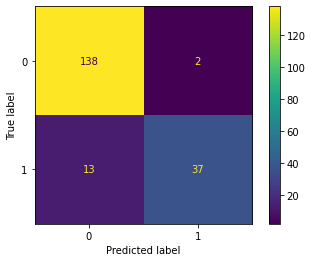

In [8]:
clf=GradientBoostingClassifier(n_estimators=100)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
y_test_pred = clf.predict_proba(X_test)
fpr_gb, tpr_gb, thr_gb = roc_curve(y_test, y_test_pred[:,1], pos_label=pos_label)
auc_gb = auc(fpr_gb, tpr_gb)
model_imp = clf.feature_importances_ #this is for RF and GBM
feature_names = list(X.columns.values)
importance = list(abs(model_imp))
importance_dict = {'Feature_names':feature_names, 'Importance':importance, 'Algorithm':'GBM', 'Gene':gene}
imp_df = pd.DataFrame(importance_dict)
imp_df_gb_ = imp_df.sort_values('Importance', ascending=False)
imp_df_gb = imp_df_gb_.head(n_top_features)

cm = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred))
sens, spec = compute_sens_spec(cm)
print("Sensitivity: " + str(round(sens,2)))
print("Specificity: " + str(round(spec,2)))
print("AUC: " + str(round(auc_gb,2)))
cm.plot()

known, potential = get_potential_drms(imp_df, stanford_mut_list)
print("No. of known DRMs: "+str(len(known)))
print("No. of other Mutations: "+str(len(potential)))

In [9]:
list_imp = [imp_df_rf, imp_df_svm, imp_df_gb]
list_imp
imp_df = pd.concat(list_imp)    
imp_df.head()

plot = (ggplot(imp_df)
    + aes(x='Feature_names', y='Importance', fill='Algorithm')
    + geom_bar(stat="identity")
    + facet_wrap('~Algorithm', scales='free') #+ facet_wrap('~Algorithm', scales='free')
    + theme(subplots_adjust={'wspace': 0.15})
    + theme(panel_background=element_rect(fill='white'),
            panel_border=element_rect(color='black',size=1),
            axis_text_x=element_text(color='black', size=15, angle=0),
            axis_text_y=element_text(color='black', size=15),
            axis_title=element_text(color='black', size=20,weight='bold'),
            legend_text=element_text(color='black', size=15),
            legend_title=element_text(color='black', size=20,weight='bold'),
            strip_text=element_text(color='black',size=20,weight='bold'),
            strip_background=element_rect(color='black', fill="white"),
            
      )
    +scale_fill_manual(values = algor_colors)
    +coord_flip()
        +theme(legend_position="none")
    + ylab('Feature importance')
    + xlab('Amino acid mutations'))
#plot.save(gene+"-importance-plot.png", width=25, height=15, dpi=300)

In [10]:
roc_dict_svm = {'FPR':fpr_svm, 'TPR':tpr_svm, 'Algorithm':'SVM', 'Gene':gene}
roc_dict_svm = pd.DataFrame(roc_dict_svm)
roc_dict_svm

roc_dict_rf = {'FPR':fpr_rf, 'TPR':tpr_rf, 'Algorithm':'RF', 'Gene':gene}
roc_df_rf = pd.DataFrame(roc_dict_rf)
roc_df_rf


roc_dict_gb = {'FPR':fpr_gb, 'TPR':tpr_gb, 'Algorithm':'GBM', 'Gene':gene}
roc_df_gb = pd.DataFrame(roc_dict_gb)
roc_df_gb


list_roc = [roc_df_rf, roc_dict_svm, roc_df_gb]
list_roc
roc_df = pd.concat(list_roc)    
roc_df.head()

plot = (ggplot(roc_df)
    + aes(x='FPR', y='TPR', color='Algorithm')
    + geom_line(size=1)
    + facet_wrap('~Algorithm', scales='free') #+ facet_wrap('~Algorithm', scales='free')
    + theme(subplots_adjust={'wspace': 0.15})
    + theme(panel_background=element_rect(fill='white'),
            panel_border=element_rect(color='black',size=1.5),
            axis_text_x=element_text(color='black', size=12, angle=0),
            axis_text_y=element_text(color='black', size=12),
            axis_title=element_text(color='black', size=15,weight='bold'),
            legend_text=element_text(color='black', size=12),
            legend_title=element_text(color='black', size=15,weight='bold'),
            strip_text=element_text(color='black',size=15,weight='bold'),
            strip_background=element_rect(color='black', fill="white"),
            
      )
    +scale_color_manual(values = algor_colors)
        +theme(legend_position="none")
    + ylab('True Positive Rate')
    + xlab('False Positive Rate'))
#plot
#plot.save(gene+"-ROC-curve.png", width=15, height=10, dpi=300)